# Verifying working of traffic light detection on real images

In [8]:
import yaml
from rosbag.bag import Bag
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
from styx_msgs.msg import TrafficLight
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import rospy
import cv2
import skvideo.io
import os

%matplotlib inline

## Define tensorflow classifier invocation class

In [9]:
class TLClassifier(object):

    def __init__(self, model_file_path):

        # Config to turn on JIT compilation
        config = tf.ConfigProto()
        config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1

        #Initialize conv net
        detection_graph = tf.Graph()
        with detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(model_file_path, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        #Initialize tensorflow session
        with detection_graph.as_default():
            sess = tf.Session(graph=detection_graph, config  = config)
        self._sess = sess

        #store tensors to run graph
        self._image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self._boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self._scores = detection_graph.get_tensor_by_name('detection_scores:0')
        self._classes = detection_graph.get_tensor_by_name('detection_classes:0')
        self._num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        #set threshold for detection
        self.THRESHOLD_SCORE = 0.6

    #format image numpy array
    def _load_image_as_nparray(self, img):
        return np.expand_dims(img, axis = 0)

    #score thresholding
    def _remove_boxes_criteria(self, boxes, scores, classes):
        #only keep boxes above a certain score
        keep_box = scores > self.THRESHOLD_SCORE
        boxes = boxes[keep_box]
        scores = scores[keep_box]
        classes = classes[keep_box]
        return boxes, scores, classes

    #detect traffic lights
    def get_classification(self, img):
        "Returns the traffic light status"

        image_batch = self._load_image_as_nparray(img)

        # Actual detection.
        (boxes, scores, classes, num_detections) = self._sess.run(
          [self._boxes, self._scores, self._classes, self._num_detections],
          feed_dict={self._image_tensor: image_batch})

        #remove singleton dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes =  np.squeeze(classes)

        [boxes, scores, classes] = self._remove_boxes_criteria(boxes, scores, classes)

        status = self._convert_light_status(classes.astype(np.int32))
        return status

    def _convert_light_status(self, classes):
        "Converts detection class to enum used in ROS Node"
        rospy.loginfo("num traffic light SSD detections %d", classes.size)
        if classes.size > 0:
            #Take the classes which occurs max
            lightclass = classes[0]
            if lightclass == 1:
                status = TrafficLight.GREEN
            elif lightclass == 2:
                status = TrafficLight.RED
            elif lightclass == 3:
                status = TrafficLight.YELLOW
            else:
                status = TrafficLight.UNKNOWN
        else:
            status = TrafficLight.UNKNOWN

        return status

In [12]:
#Load SSD detector
ssd_real_model_path = './frozen_models/frozen_real_inception/frozen_inference_graph.pb'
classifier = TLClassifier(ssd_real_model_path)
classifier.get_classification(np.ones((1096, 1368, 3)).astype(np.uint8))

4

In [21]:
#image conversion utilities
bridge = CvBridge()
bag_file = 'loop_with_traffic_light.bag'

In [22]:
#Read image messages from bag files and process them

out_folder = 'output_images'

font = cv2.FONT_HERSHEY_SIMPLEX
yellow = (225, 225, 0)
green = (0, 225, 0)
red = (225, 0, 0)
white = (225, 225, 225)

save_every = 100
images = []
status = []
count = 0

outfilename = os.path.basename(bag_file).split('.')[0] + '.mp4'
print("Writing video to " + outfilename)

writer = skvideo.io.LibAVWriter(outfilename)

for topic, msg, t in Bag(bag_file).read_messages(topics = '/image_raw'):
    cv_img = bridge.imgmsg_to_cv2(msg, "rgb8")
    np_img = np.array(cv_img)
    light = classifier.get_classification(np_img)
     #print( (endT - beginT )* 1e3 + ' ms')
    if light == TrafficLight.GREEN:
        lightstr = 'green'
        color = green
    elif light == TrafficLight.RED:
        lightstr = 'red'
        color = red
    elif light == TrafficLight.YELLOW:
        lightstr = 'yellow'
        color = yellow
    elif light == TrafficLight.UNKNOWN:
        lightstr = 'unknown'
        color = white
    cv2.putText(np_img,lightstr,(10,100), font, 3,color,2,cv2.LINE_AA)
    writer.writeFrame(np_img)

writer.close()

Writing video to loop_with_traffic_light.mp4
['/usr/bin/avconv', '-y', '-f', 'rawvideo', '-pix_fmt', 'rgb24', '-s', '1368x1096', '-i', 'pipe:', '-sws_flags', 'bitexact', 'loop_with_traffic_light.mp4']


In [16]:
print("car light status: " + lightstr)

car light status: yellow


In [17]:
print(np_img.shape)

(1096, 1368, 3)


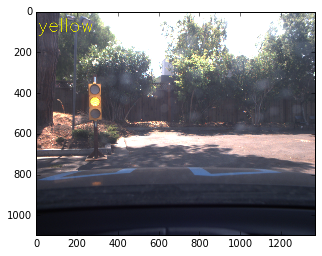

In [18]:
font = cv2.FONT_HERSHEY_SIMPLEX
yellow = (225, 225, 0)
green = (0, 225, 0)
red = (225, 0, 0)
cv2.putText(np_img,'yellow',(10,100), font, 3,yellow,2,cv2.LINE_AA)
plt.imshow(np_img)